In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse

# Load the data
train_data = pd.read_csv("tmp/filtered_data.csv")
test_data = pd.read_parquet("data/test_data.parquet")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

In [90]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [91]:
# Filter rows with the specified expiry date
expiry_filter = train_data["expiry"].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


In [92]:
call_cols = [col for col in train_data.columns if col.startswith("call")]
put_cols = [col for col in train_data.columns if col.startswith("put")]

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm
from multiprocess import Pool, cpu_count


def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma**2))


# --- Fit SVI to one row ---
def fitSVI_row(args):

    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize

    # --- SVI formula ---
    def svi_total_variance(k, a, b, rho, m, sigma):
        return a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma**2))

    row, cols, T = args
    # print(row.index)
    ivs = row[cols].values.astype(np.float64)
    strikes = np.array([float(c.split("_")[-1]) for c in cols])
    F = row["underlying"]
    k = np.log(strikes / F)

    valid = ~np.isnan(ivs)
    if valid.sum() < 5:
        return ivs  # not enough data

    iv_valid = ivs[valid]
    w_valid = iv_valid**2 * T
    k_valid = k[valid]

    def loss(params):
        a, b, rho, m, sigma = params
        w_fit = svi_total_variance(k_valid, a, b, rho, m, sigma)
        return np.mean((w_valid - w_fit) ** 2)

    init = [min(w_valid), 0.1, 0.0, np.mean(k_valid), 1]
    bounds = [
        (0, 2),
        (1e-4, 5),
        (-0.999, 0.999),
        (-2, 2),
        (0.1, 2),
    ]

    res = minimize(loss, init, bounds=bounds, method="L-BFGS-B")
    if not res.success:
        return ivs

    w_fitted = svi_total_variance(k, *res.x)
    iv_fitted = np.sqrt(w_fitted / T)
    # ivs[~valid] = iv_fitted[~valid]
    return iv_fitted


# --- Plot SVI fit for a specific row ---
def plotSVI(prediction,index, cols, df):
    row = df.iloc[index]
    ivs = row[cols].values.astype(np.float64)
    strikes = np.array([float(c.split("_")[-1]) for c in cols])

    valid = ~np.isnan(ivs)
    iv_valid = ivs[valid]

    plt.figure(figsize=(8, 4))
    plt.scatter(strikes, iv_valid, label="Observed IVs", color="blue")
    plt.plot(strikes, prediction, label="SVI Fit", color="red")
    plt.xlabel("Strikes")
    plt.ylabel("Implied Volatility")
    plt.title(f"Fit at index {index}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [117]:
print(fitSVI_row((train_data.iloc[0], call_cols, 1.0)))
print(fitSVI_row((train_data.iloc[0], put_cols, 1.0)).__len__(), call_cols.__len__())

[0.5993501  0.60062033 0.60188817 0.60315362 0.60441668 0.60567734
 0.60693559 0.60819143 0.60944484 0.61069583 0.61194439 0.6131905
 0.61443417 0.61567539 0.61691415 0.61815044 0.61938428 0.62061564
 0.62184452 0.62307092 0.62429484 0.62551626 0.6267352  0.62795163
 0.62916556 0.63037699]
26 26


In [96]:
print(train_data.isna().sum().sum())
train_data.dropna(subset=call_cols + put_cols, inplace=True)

315


In [98]:
train_data.shape

(138453, 97)

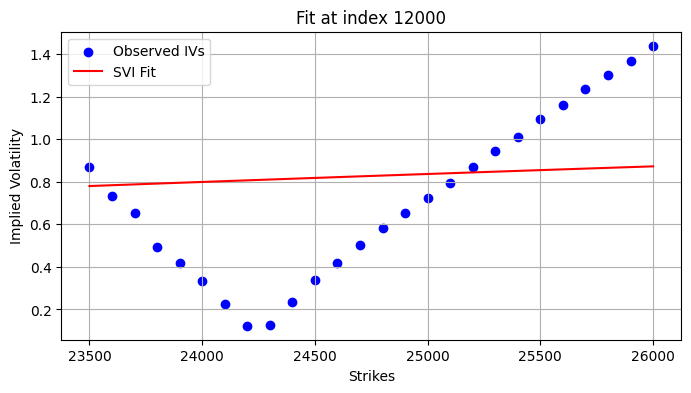

In [128]:
plotSVI(
    fitSVI_row((train_data.iloc[12000], call_cols, 1.0)), 12000, call_cols, train_data
)

In [106]:
from sklearn.metrics import mean_squared_error as mse
print(mse(fit_cubic_spline_row(train_data.iloc[1000], call_cols, 1), train_data.iloc[1000][call_cols].values.astype(np.float64)))

[0.670652 0.587549 0.52022  0.444456 0.376451 0.307468 0.236352 0.17202
 0.181453 0.253615 0.314909 0.37197  0.432698 0.489569 0.533093 0.578103
 0.631264 0.674912 0.717263 0.769936 0.821563 0.851292 0.914199 0.961447
 0.994267 1.05584 ]
0.0


In [ ]:
def parallel_fitSVI(df, cols, T=1.0, processes=None, batch_size=500):
    if processes is None:
        processes = max(cpu_count() - 1, 1)
    print("Starting parallel SVI fitting with", processes, "processes")
    df_filled = df.copy()
    n = len(df)
    for start in tqdm(range(0, n, batch_size), desc="Fitting SVI"):
        end = min(start + batch_size, n)
        batch = df.iloc[start:end]
        args = [(row, cols, T) for _, row in batch.iterrows()]

        with Pool(processes) as pool:
            results = pool.map(fitSVI_row, args)

        for i, new_ivs in enumerate(results):
            df_filled.iloc[start + i, df.columns.get_indexer(cols)] = new_ivs

    return df_filled